# Load documents with IDs

In [1]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load groud truth

In [3]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [6]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [7]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

In [6]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

Before running this code make sure to run the docker

In [11]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [12]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

## Retrieval

In [13]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [14]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG flow

In [15]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [17]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [18]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [20]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [21]:
rag(ground_truth[10])

'Yes, sessions are recorded, so if you miss one, you won’t miss anything. You will still have the opportunity to ask questions in advance for office hours, which are also recorded and can be watched later. Additionally, you can always ask questions in Slack.'

In [23]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity

In [24]:
answer_orig = 'Yes, sessions are recorded, so if you miss one, you won’t miss anything. You will still have the opportunity to ask questions in advance for office hours, which are also recorded and can be watched later. Additionally, you can always ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

# this is how you calculate the similarity
v_llm.dot(v_orig)

0.7693583

In [25]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [ ]:
answers = {}

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

   # answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }
    
    

## Evaluating GPT 3.5

In [31]:
rag(ground_truth[10], model='gpt-3.5-turbo')

"Yes, sessions are recorded so if you miss one, you won't miss anything."

The following code is for running thins in paralell and speed up the process

In [ ]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [33]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [34]:
process_record(ground_truth[10])

{'answer_llm': 'Yes, sessions are recorded if you miss one. You can catch up by watching the recorded sessions and ask questions either during office hours or on Slack.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
# although this is faster if it breaks at some point you cannot start where you left as you can with the sequential approach (loop)
#results_gpt35 = map_progress(pool, ground_truth, process_record)

After running gpt4o and gpt3.5 we find out that gpt3.5 is 10 times cheaper, with a cost of around $0,17, while gpt40 costs around $10

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

In [ ]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [1]:
import pandas as pd
df_gpt4o = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o.csv')
df_gpt35 = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt35.csv')

In [9]:
from tqdm.auto import tqdm
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [3]:
results_gpt4o[0]

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [4]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    # this is how you calculate the similarity
    return v_llm.dot(v_orig)

## GPT4o

In [7]:
compute_similarity(results_gpt4o[0])

0.53453285

In [10]:
similarity = []
for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [11]:
df_gpt4o['cosine'] = similarity

In [12]:
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [14]:
import seaborn as sns

/tmp/ipykernel_4736/2967343473.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

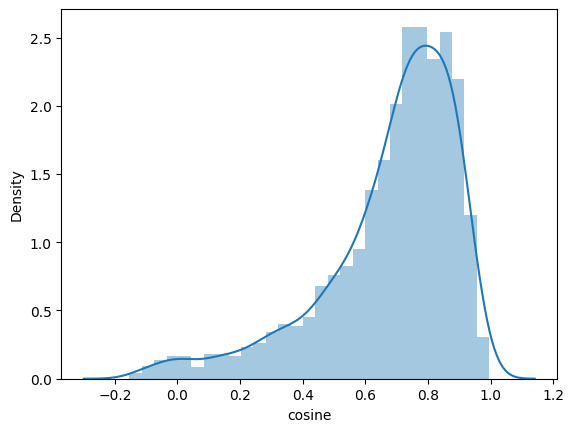

In [16]:
sns.distplot(df_gpt4o['cosine'])

## GPT 3.5

In [18]:
results_gpt35 = df_gpt35.to_dict(orient='records')

In [19]:
compute_similarity(results_gpt35[0])

0.42182237

In [20]:
similarity_35 = []
for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [22]:
df_gpt35['cosine'] = similarity_35

In [24]:
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [26]:
import matplotlib.pyplot as plt

/tmp/ipykernel_4736/2081258822.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label = '4o')
/tmp/ipykernel_4736/2081258822.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5')


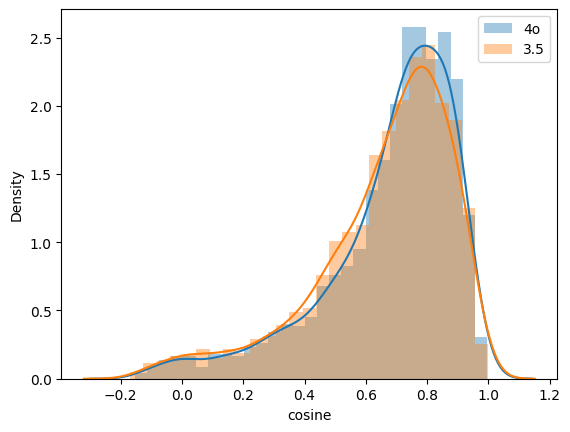

In [28]:
sns.distplot(df_gpt4o['cosine'], label = '4o')
sns.distplot(df_gpt35['cosine'], label='3.5')

plt.legend()

In [31]:
df_gpt4o_mini = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o-mini.csv')

In [32]:
results_gpt4o_mini = df_gpt4o_mini .to_dict(orient='records')

In [33]:
compute_similarity(results_gpt4o_mini[0])

0.38859457

In [34]:
similarity_4omini = []
for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity(record)
    similarity_4omini.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [35]:
df_gpt4o_mini['cosine'] = similarity_4omini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

/tmp/ipykernel_4736/1703849691.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label = '4o')
/tmp/ipykernel_4736/1703849691.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5')
/tmp/ipykernel_4736/1703849691.py:3: UserWarning: 

`distplot` 

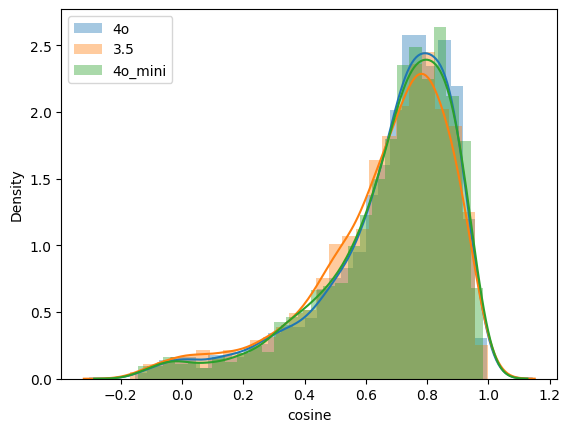

In [36]:
sns.distplot(df_gpt4o['cosine'], label = '4o')
sns.distplot(df_gpt35['cosine'], label='3.5')
sns.distplot(df_gpt4o_mini['cosine'], label='4o_mini')

plt.legend()

Based on the results it is clear that the three models perform similar in our dataset, suggesting that we should go with the less expensive model, in this case gp4o.